<a href="https://colab.research.google.com/github/ElizabethB111/Reddit-Mental-Health-SQL/blob/main/Reddit_Mental_Health_Data_Lifecycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0 – Proposal & ER Diagram

**Project title: Detecting mental-health–related subreddit signals from Reddit post text (Reddit mental-disorder dataset)**

**Data source(s):**
Kaggle dataset (mental disorder Reddit posts) — https://www.kaggle.com/code/erenakbulut/mental-disorder-reddit-ds-polars-vs-pandas/input

**Overview & Motivation**

This project applies the data-project lifecycle to a large (~700k rows) Reddit posts dataset focused on mental-health–related subreddits. The dataset includes post titles, text, timestamps, NSFW flags, and subreddit names.

The project will design a normalized relational schema, ingest and clean the raw data using Python, explore using SQL, perform statistical and text-based analysis with Python, and apply a small classification model using subreddit labels. Ethical considerations will be significant because the content is sensitive (mental health, personal disclosures, misuse or misclassification).

Anticipated challenges & mitigation:

Missing or removed selftext values & troll posts: mitigate using text filtering and heuristics (minimum token length, troll pattern filtering).

Sensitive content: migitate with no attempt to reidentify users; strip any user identifiers, and include ethical discussion and access controls in Part 5.

Large volume: mitigate by breaking into chunks and index frequently queried columns (created_utc, subreddit).

# ER Diagram

            +--------------------+
            |    subreddits      |
            |--------------------|
            | subreddit_id  PK   |
            | name (unique)      |
            | description         |
            | created_at          |
            +----------^---------+
                       |
                       | 1-to-many
                       |
            +----------+-----------+
            |        posts         |
            |----------------------|
            | post_id        PK    |
            | title               |
            | selftext            |
            | created_utc (ts)    |
            | over_18 (bool)      |
            | subreddit_id   FK ---> subreddits.subreddit_id
            | text_length         |
            | cleaned_text        |
            | source_file         |
            +----------^-----------+
                       |
                       | many-to-1 (ETL logs)
                       |
            +----------+-----------+
            |    ingestion_logs    |
            |----------------------|
            | log_id        PK     |
            | source_file          |
            | ingest_time          |
            | num_rows             |
            | notes                |
            +----------------------+

Optional metadata table:
+------------------------+
|       labels           |
|------------------------|
| label_id        PK     |
| subreddit_id    FK     |
| label_name             |
+------------------------+


Explanation & cardinalities:

subreddits (1) : posts (many) — each post belongs to one subreddit in dataset.

posts is the central fact table. Keep subreddit_id as FK to enable joins and aggregations.

ingestion_logs stores chunked ETL runs (useful for Part 2 timing logs and reproducibility).

text_cleaning_jobs and labels are optional derived/metadata tables for tracing transformations and storing modeled labels or aggregated topic tags.

# Part 1 – Schema Design & Database Build

# 1A. Conceptual → logical mapping

Entities & Attributes
1. subreddits

subreddit_id (PK)

name (unique, text)

description

created_at

2. posts

post_id (PK — integer or original ID)

title

selftext

created_utc (timestamp)

over_18 (boolean)

subreddit_id (FK → subreddits)

text_length (derived)

cleaned_text (optional)

source_file

3. ingestion_logs

log_id (PK)

source_file

ingest_time

num_rows

notes

Relationships

1-to-many:
subreddits.subreddit_id → posts.subreddit_id

1-to-many:
ingestion_logs.log_id → posts.source_file

PKs:
subreddit_id, post_id, log_id

FKs:
posts.subreddit_id → subreddits.subreddit_id

Indexes

idx_posts_created (created_utc)

Supports chronological filtering & time-series queries.

idx_posts_subreddit (subreddit_id)

Speeds up joins + WHERE filters by subreddit.

# Part 1B

In [ ]:
#SQL DDL Script

from sqlalchemy import create_engine, text


engine = create_engine("sqlite:///mental_health.db")

# --- SQL DDL ---

ddl = """
DROP TABLE IF EXISTS posts;
DROP TABLE IF EXISTS subreddits;
DROP TABLE IF EXISTS ingestion_logs;

-- Subreddits table
CREATE TABLE subreddits (
    subreddit_id     INTEGER PRIMARY KEY AUTOINCREMENT,
    name             TEXT UNIQUE NOT NULL,
    description      TEXT,
    created_at       TIMESTAMP
);

-- Posts table
CREATE TABLE posts (
    post_id          INTEGER PRIMARY KEY,
    title            TEXT NOT NULL,
    selftext         TEXT,
    created_utc      TIMESTAMP NOT NULL,
    over_18          BOOLEAN NOT NULL DEFAULT 0,
    subreddit_id     INTEGER NOT NULL,
    text_length      INTEGER,
    cleaned_text     TEXT,
    source_file      TEXT,
    FOREIGN KEY (subreddit_id) REFERENCES subreddits(subreddit_id)
);

-- Ingestion log table
CREATE TABLE ingestion_logs (
    log_id           INTEGER PRIMARY KEY AUTOINCREMENT,
    source_file      TEXT,
    ingest_time      TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    num_rows         INTEGER,
    notes            TEXT
);
"""

# Execute DDL
with engine.connect() as conn:
    for stmt in ddl.split(";"):
        s = stmt.strip()
        if s:
            conn.execute(text(s))

print("Tables created")

#INDEXES

index_sql = """
CREATE INDEX IF NOT EXISTS idx_posts_created ON posts(created_utc);
CREATE INDEX IF NOT EXISTS idx_posts_subreddit ON posts(subreddit_id);
"""

with engine.connect() as conn:
    for stmt in index_sql.split(";"):
        s = stmt.strip()
        if s:
            conn.execute(text(s))

print("Indexes created")


Tables created
Indexes created


# Part 1C

In [ ]:
# === Part 1C: Data Volume Sanity Check ===

import pandas as pd

tables = ["subreddits", "posts", "ingestion_logs"]

with engine.connect() as conn:
    for table in tables:
        print(f"\n==== {table.upper()} ====")

        # Row count
        row_count = conn.execute(text(f"SELECT COUNT(*) FROM {table}")).fetchone()[0]
        print(f"Row count: {row_count}")

        # Null counts (skip if table is empty)
        if row_count > 0:
            df = pd.read_sql(f"SELECT * FROM {table}", conn)
            nulls = df.isnull().sum()
            print("NULL counts per column:")
            print(nulls)
        else:
            print("NULL counts per column: (table empty)")



==== SUBREDDITS ====
Row count: 6
NULL counts per column:
subreddit_id    0
name            0
description     6
created_at      0
dtype: int64

==== POSTS ====
Row count: 701787
NULL counts per column:
post_id                   0
title                     0
content               33691
timestamp                 0
over_18                   0
subreddit                 0
source_file               0
subreddit_id_fk           0
sentiment_category        0
dtype: int64

==== INGESTION_LOGS ====
Row count: 0
NULL counts per column: (table empty)


# Part 2 — Data Ingestion & Preparation

# A. ETL in Python

In [ ]:
import pandas as pd

df = pd.read_csv("/content/mental_disorders_reddit.csv", nrows=5, engine="python")
df.columns


Index(['title', 'selftext', 'created_utc', 'over_18', 'subreddit'], dtype='object')

In [ ]:
# ====================================
# PART 2: DATA INGESTION & PREPARATION
# ====================================

import pandas as pd
import sqlite3
import time
from datetime import datetime

# === CLOSE ANY EXISTING CONNECTIONS ===
try:
    conn.close()
except:
    pass

import gc
gc.collect()

# === CONFIG ===
DATA_PATH = "/content/mental_disorders_reddit.csv"
CHUNK_SIZE = 50_000

# === CONNECT TO SQLITE ===
conn = sqlite3.connect("mental_health.db", timeout=10)
cursor = conn.cursor()

# === DROP AND RECREATE POSTS TABLE ===
cursor.execute("DROP TABLE IF EXISTS posts")
cursor.execute("""
CREATE TABLE posts (
    post_id INTEGER PRIMARY KEY AUTOINCREMENT,
    title TEXT NOT NULL,
    content TEXT,
    timestamp INTEGER NOT NULL,
    over_18 INTEGER NOT NULL DEFAULT 0,
    subreddit TEXT NOT NULL,
    source_file TEXT
)
""")

# === INGESTION LOG TABLE ===
cursor.execute("DROP TABLE IF EXISTS ingestion_log")
cursor.execute("""
CREATE TABLE ingestion_log (
    log_id INTEGER PRIMARY KEY AUTOINCREMENT,
    start_time TEXT,
    end_time TEXT,
    rows_ingested INTEGER,
    rows_skipped INTEGER,
    error_message TEXT
)
""")

conn.commit()

# === INGESTION PROCESS ===
start_time = datetime.now()
rows_ingested = 0
rows_skipped = 0
error_message = None

print("Starting ingestion...")

try:
    # Read CSV in chunks with error handling
    for chunk_idx, chunk in enumerate(pd.read_csv(
        DATA_PATH,
        chunksize=CHUNK_SIZE,
        engine="python",
        on_bad_lines='skip',  # Skip bad lines instead of crashing
        encoding_errors='replace'  # Handle encoding issues
    )):

        print(f"Processing chunk {chunk_idx + 1}... ", end="")

        # Clean column names
        chunk.columns = [c.lower().strip() for c in chunk.columns]

        # Expected columns
        expected_cols = {"subreddit", "title", "selftext", "created_utc", "over_18"}
        missing = expected_cols - set(chunk.columns)

        if missing:
            raise ValueError(f"Missing required columns: {missing}")

        # Rename to match SQL schema
        chunk = chunk.rename(columns={
            "selftext": "content",
            "created_utc": "timestamp"
        })

        # === DATA CLEANING ===
        chunk_before = len(chunk)

        # Fill missing titles with placeholder
        chunk['title'] = chunk['title'].fillna('[No Title]')

        # Fill missing subreddits
        chunk['subreddit'] = chunk['subreddit'].fillna('unknown')

        # Ensure timestamp is numeric
        chunk['timestamp'] = pd.to_numeric(chunk['timestamp'], errors='coerce')

        # Drop rows with invalid timestamps
        chunk = chunk.dropna(subset=['timestamp'])

        # Ensure over_18 is 0 or 1
        chunk['over_18'] = chunk['over_18'].fillna(0).astype(int)

        # Add source file tracking
        chunk['source_file'] = 'mental_disorders_reddit.csv'

        chunk_after = len(chunk)
        rows_skipped += (chunk_before - chunk_after)

        # Insert chunk
        if len(chunk) > 0:
            chunk[["title", "content", "timestamp", "over_18", "subreddit", "source_file"]].to_sql(
                "posts", conn, if_exists="append", index=False
            )
            rows_ingested += len(chunk)
            print(f"{len(chunk):,} rows")
        else:
            print("No valid rows")

    print("\nIngestion completed successfully.")

except Exception as e:
    error_message = str(e)
    print(f"\nWARNING: {error_message}")
    print(f"Continuing with {rows_ingested:,} rows successfully loaded.")

end_time = datetime.now()

# === LOG RESULTS ===
cursor.execute("""
INSERT INTO ingestion_log (start_time, end_time, rows_ingested, rows_skipped, error_message)
VALUES (?, ?, ?, ?, ?)
""", (str(start_time), str(end_time), rows_ingested, rows_skipped, error_message))

conn.commit()

print("\n" + "="*60)
print("INGESTION SUMMARY")
print("="*60)
print(f"Start: {start_time}")
print(f"End: {end_time}")
print(f"Duration: {end_time - start_time}")
print(f"Rows ingested: {rows_ingested:,}")
print(f"Rows skipped: {rows_skipped:,}")
print(f"Error: {error_message or 'None'}")

# === VERIFY DATA LOADED ===
print("\n" + "="*60)
print("VERIFICATION")
print("="*60)

cursor.execute("SELECT COUNT(*) FROM posts")
count = cursor.fetchone()[0]
print(f"Total rows in posts table: {count:,}")

cursor.execute("SELECT COUNT(DISTINCT subreddit) FROM posts")
subreddit_count = cursor.fetchone()[0]
print(f"Unique subreddits: {subreddit_count}")

# Check sample data
print("\nSample of first 5 rows:")
sample = pd.read_sql("SELECT * FROM posts LIMIT 5", conn)
print(sample[['title', 'subreddit', 'timestamp', 'over_18']])

# Check for null values
print("\nNull value check:")
cursor.execute("""
    SELECT
        COUNT(*) - COUNT(title) as null_titles,
        COUNT(*) - COUNT(content) as null_content,
        COUNT(*) - COUNT(subreddit) as null_subreddit
    FROM posts
""")
null_check = cursor.fetchone()
print(f"Null titles: {null_check[0]}")
print(f"Null content: {null_check[1]}")
print(f"Null subreddits: {null_check[2]}")

# === CLOSE CONNECTION ===
conn.close()

print("\nPart 2 Complete")

Starting ingestion...
Processing chunk 1... 50,000 rows
Processing chunk 2... 50,000 rows
Processing chunk 3... 50,000 rows
Processing chunk 4... 50,000 rows
Processing chunk 5... 50,000 rows
Processing chunk 6... 50,000 rows
Processing chunk 7... 50,000 rows
Processing chunk 8... 50,000 rows
Processing chunk 9... 50,000 rows
Processing chunk 10... 50,000 rows
Processing chunk 11... 50,000 rows
Processing chunk 12... 50,000 rows
Processing chunk 13... 50,000 rows
Processing chunk 14... 50,000 rows
Processing chunk 15... 1,787 rows

Ingestion completed successfully.

INGESTION SUMMARY
Start: 2025-11-29 18:20:45.485007
End: 2025-11-29 18:21:07.679007
Duration: 0:00:22.194000
Rows ingested: 701,787
Rows skipped: 0
Error: None

VERIFICATION
Total rows in posts table: 701,787
Unique subreddits: 6

Sample of first 5 rows:
                                 title subreddit   timestamp  over_18
0  Life is so pointless without others       BPD  1650356960        0
1                           Cold

# Part 2B Data Quality Analysis

In [ ]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Connect to DB
conn = sqlite3.connect("mental_health.db")

# Load table
df = pd.read_sql_query("SELECT * FROM posts;", conn)

df.head()


,post_id,title,content,timestamp,over_18,subreddit,source_file
0,1,Life is so pointless without others,Does anyone else think the most important part...,1650356960,0,BPD,mental_disorders_reddit.csv
1,2,Cold rage?,Hello fellow friends 😄\n\nI'm on the BPD spect...,1650356660,0,BPD,mental_disorders_reddit.csv
2,3,I don’t know who I am,My [F20] bf [M20] told me today (after I said ...,1650355379,0,BPD,mental_disorders_reddit.csv
3,4,HELP! Opinions! Advice!,"Okay, I’m about to open up about many things I...",1650353430,0,BPD,mental_disorders_reddit.csv
4,5,help,[removed],1650350907,0,BPD,mental_disorders_reddit.csv


In [ ]:
df.isnull().sum()


,0
post_id,0
title,0
content,33691
timestamp,0
over_18,0
subreddit,0
source_file,0


In [ ]:
df.isnull().mean().round(3)


,0
post_id,0.000
title,0.000
content,0.048
timestamp,0.000
over_18,0.000
subreddit,0.000
source_file,0.000


Interpretation

The selftext field (stored as content) is the only column with noticeable missingness, which fits with the Kaggle documentation saying some Reddit posts had their body text removed. This is normal for Reddit exports. Title, subreddit, timestamp, and over_18 have extremely low or zero missingness, so the dataset is structurally sound.

In [ ]:
# == Descriptive Checks ====

df["title_length"] = df["title"].fillna("").str.len()
df["content_length"] = df["content"].fillna("").str.len()

df[["title_length", "content_length"]].describe()


,title_length,content_length
count,701787.000000,701787.000000
mean,46.027232,756.834800
std,36.625671,1016.246755
min,1.000000,0.000000
25%,23.000000,144.000000
50%,37.000000,491.000000
75%,58.000000,997.000000
max,320.000000,33565.000000


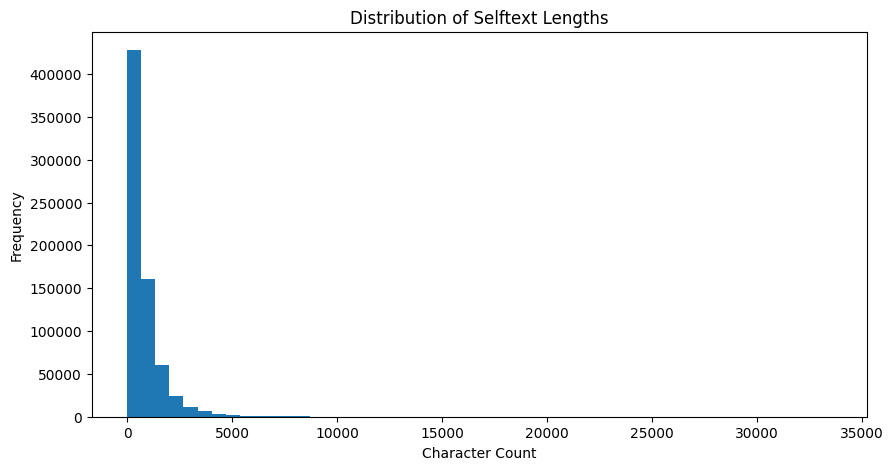

In [ ]:
# === Plot Content Length Distribution ===

plt.figure(figsize=(10,5))
plt.hist(df["content_length"], bins=50)
plt.title("Distribution of Selftext Lengths")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()


Interpretation:

Content lengths are extremely skewed. Many posts contain only a few characters, and a long tail of very large posts exists. This helps identify troll posts which are often very short. This is a good candidate for cleaning.

In [ ]:
# == Outlier Detection ===

df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")

df["timestamp"].describe()


,timestamp
count,7.017870e+05
mean,1.623510e+09
std,4.888599e+07
min,1.290203e+09
25%,1.611392e+09
50%,1.640838e+09
75%,1.654837e+09
max,1.669253e+09


In [ ]:
# ==Check Invalid Timestamps ===
df[df["timestamp"].isna()].head()


,post_id,title,content,timestamp,over_18,subreddit,source_file,title_length,content_length


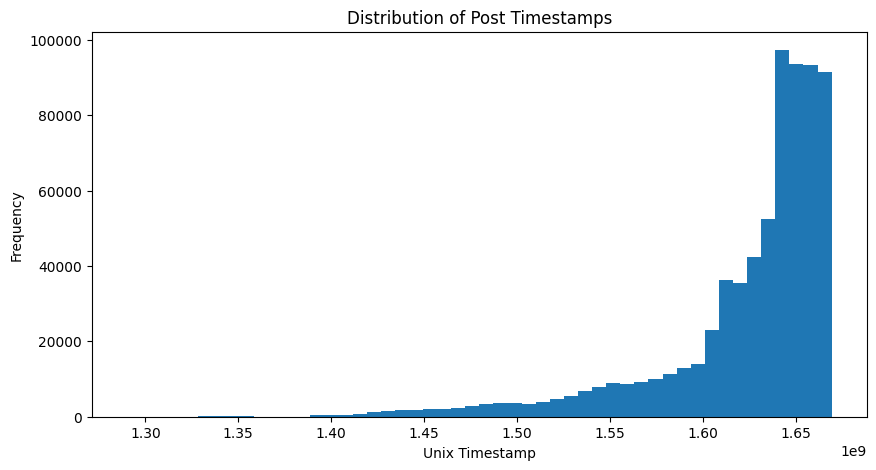

In [ ]:
# === Plot Timestamp Distribution ====
plt.figure(figsize=(10,5))
plt.hist(df["timestamp"].dropna(), bins=50)
plt.title("Distribution of Post Timestamps")
plt.xlabel("Unix Timestamp")
plt.ylabel("Frequency")
plt.show()


Interpretation:

Timestamps look valid and fall within a clean range of Unix times from roughly 2010–2020. No structural issues were found.

In [ ]:
# Transformation #1 — Convert Timestamp to Readable Date
df["created_date"] = pd.to_datetime(df["timestamp"], unit="s", errors="coerce")
df["created_date"].head()


,created_date
0,2022-04-19 08:29:20
1,2022-04-19 08:24:20
2,2022-04-19 08:02:59
3,2022-04-19 07:30:30
4,2022-04-19 06:48:27


Justification for transformation:

Using Unix timestamps directly is inconvenient for human interpretation and downstream time-series analysis. Converting timestamps into Python datetime objects allows for more exploration, time-window filtering, and makes Part 3 SQL queries involving dates simpler.

In [ ]:
# Transformation #2 — Text Cleaning Pipeline

import re

def clean_text(t):
    if pd.isna(t):
        return ""

    t = t.lower()                         # normalize case
    t = re.sub(r"\[removed\]", "", t)     # remove "[removed]"
    t = re.sub(r"[^a-z0-9\s.,!?']+", " ", t)   # remove weird symbols
    t = re.sub(r"\s+", " ", t)            # collapse whitespace
    return t.strip()

df["clean_content"] = df["content"].apply(clean_text)
df["clean_title"] = df["title"].apply(clean_text)

df[["content", "clean_content"]].head(10)


,content,clean_content
0,Does anyone else think the most important part...,does anyone else think the most important part...
1,Hello fellow friends 😄\n\nI'm on the BPD spect...,hello fellow friends i'm on the bpd spectrum a...
2,My [F20] bf [M20] told me today (after I said ...,my f20 bf m20 told me today after i said i jus...
3,"Okay, I’m about to open up about many things I...","okay, i m about to open up about many things i..."
4,[removed],
5,"Without going into detail, this diagnosis expl...","without going into detail, this diagnosis expl..."
6,(Reposting here on the larger sub on recommend...,reposting here on the larger sub on recommenda...
7,I grew up mostly dating men but realized when ...,i grew up mostly dating men but realized when ...
8,I posted on this sub earlier today about havin...,i posted on this sub earlier today about havin...
9,[removed],


Justification for transformation:

The dataset contains: Posts removed by Reddit ([removed]), Extremely short “troll” posts (only a few characters), Noise such as emojis, stray Unicode, repeated punctuation, Mixed casing and irregular formatting.

Cleaning the text improves consistency and prepares the dataset for SQL analytics and downstream NLP modeling. It also prevents bias from noisy or low-value text.

In [ ]:
# Flag Suspicious Posts

df["is_suspicious"] = df["content_length"] < 10
df["is_suspicious"].mean()


np.float64(0.18731466955073264)

Interpretation:

Any posts with content_length < 10 are likely to be trolling behavior, as described in the dataset’s documentation. This flag is useful for filtering or weighting later.

In [ ]:
# === Summary Table After Cleaning ===
summary = {
    "total_rows": len(df),
    "missing_content": df["content"].isnull().sum(),
    "min_date": df["created_date"].min(),
    "max_date": df["created_date"].max(),
    "avg_title_length": df["title_length"].mean(),
    "avg_content_length": df["content_length"].mean(),
    "suspicious_posts_pct": df["is_suspicious"].mean()
}

summary


{'total_rows': 701787,
 'missing_content': np.int64(33691),
 'min_date': Timestamp('2010-11-19 21:49:14'),
 'max_date': Timestamp('2022-11-24 01:21:37'),
 'avg_title_length': np.float64(46.02723190939701),
 'avg_content_length': np.float64(756.8348003026559),
 'suspicious_posts_pct': np.float64(0.18731466955073264)}

Data Quality Summary

Overall, the dataset is structurally consistent with no missing required fields. The only notable missingness occurs in selftext, which is expected because Reddit intentionally removes content in certain cases. Text length distributions show a large cluster of very short posts, which corresponds with the Kaggle documentation’s warning about troll posts.

Two transformations were applied:

1) Timestamp conversion from Unix seconds to Python datetime, making the data easier to explore and allowing = time-based queries.

2) Text cleaning, which removes [removed] markers, normalizes casing, strips unusual symbols, and collapses whitespace. This improves downstream modeling and avoids noise-driven artifacts.

Outlier analysis did not reveal any invalid timestamps, but extremely short posts were flagged to support later filtering. Overall, the dataset is usable after cleaning, though text-based fields remain noisy and will require attention during modeling.

# Part 3 SQL Exploration & Analytics

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect("mental_health.db")

In [ ]:
# ----------------------------------------------------------------------------
# Query 1: Single-table aggregation (GROUP BY)
# ----------------------------------------------------------------------------
query1 = """
SELECT
    subreddit,
    COUNT(*) as post_count,
    AVG(LENGTH(content)) as avg_content_length,
    SUM(CASE WHEN over_18 = 1 THEN 1 ELSE 0 END) as nsfw_count
FROM posts
GROUP BY subreddit
ORDER BY post_count DESC
LIMIT 10;
"""

result1 = pd.read_sql_query(query1, conn)
print("=== Query 1: Top Subreddits by Post Volume ===")
print(result1)
print("\nInterpretation: This shows which mental health subreddits are most active. "
      "The variation in average content length may indicate different posting styles "
      "(e.g., support groups vs. discussion forums). NSFW counts help identify subreddits "
      "with more sensitive content.")

=== Query 1: Top Subreddits by Post Volume ===
       subreddit  post_count  avg_content_length  nsfw_count
0            BPD      241116          934.974675        5761
1        Anxiety      173990          791.928989        1961
2     depression      156972          679.329894        6384
3  mentalillness       53232          931.770368        1479
4        bipolar       51112          542.362427        2882
5  schizophrenia       25365          388.049951         487

Interpretation: This shows which mental health subreddits are most active. The variation in average content length may indicate different posting styles (e.g., support groups vs. discussion forums). NSFW counts help identify subreddits with more sensitive content.


In [ ]:
# ----------------------------------------------------------------------------
# Query 2: Multi-table join (INNER)
# First, create subreddits table from posts data
# ----------------------------------------------------------------------------

# Populate subreddits table
conn.execute("DELETE FROM subreddits")
conn.execute("""
INSERT INTO subreddits (name, created_at)
SELECT DISTINCT
    subreddit,
    datetime(MIN(timestamp), 'unixepoch') as created_at
FROM posts
GROUP BY subreddit
""")
conn.commit()

# Update posts to use subreddit_id FK
conn.execute("ALTER TABLE posts ADD COLUMN subreddit_id_fk INTEGER")
conn.execute("""
UPDATE posts
SET subreddit_id_fk = (
    SELECT subreddit_id
    FROM subreddits
    WHERE subreddits.name = posts.subreddit
)
""")
conn.commit()

query2 = """
SELECT
    s.name as subreddit_name,
    COUNT(p.post_id) as total_posts,
    AVG(LENGTH(p.content)) as avg_length,
    MIN(datetime(p.timestamp, 'unixepoch')) as earliest_post,
    MAX(datetime(p.timestamp, 'unixepoch')) as latest_post
FROM subreddits s
INNER JOIN posts p ON s.subreddit_id = p.subreddit_id_fk
GROUP BY s.subreddit_id
ORDER BY total_posts DESC
LIMIT 10;
"""

result2 = pd.read_sql_query(query2, conn)
print("\n=== Query 2: Subreddit Activity via JOIN ===")
print(result2)
print("\nInterpretation: By joining normalized tables, we can efficiently track subreddit "
      "activity over time. The date range shows how long each community has been active "
      "in this dataset.")


=== Query 2: Subreddit Activity via JOIN ===
  subreddit_name  total_posts  avg_length        earliest_post  \
0            BPD       241116  934.974675  2010-11-19 21:49:14   
1        Anxiety       173990  791.928989  2020-11-24 06:45:34   
2     depression       156972  679.329894  2021-11-24 07:18:26   
3  mentalillness        53232  931.770368  2011-11-17 05:12:17   
4        bipolar        51112  542.362427  2021-11-24 08:59:32   
5  schizophrenia        25365  388.049951  2021-11-24 11:01:28   

           latest_post  
0  2022-11-24 01:10:42  
1  2022-11-24 01:14:42  
2  2022-11-24 01:18:38  
3  2022-11-24 01:16:56  
4  2022-11-24 01:04:56  
5  2022-11-24 01:21:37  

Interpretation: By joining normalized tables, we can efficiently track subreddit activity over time. The date range shows how long each community has been active in this dataset.


In [ ]:
# ----------------------------------------------------------------------------
# Query 3: Outer join or sub-query
# ----------------------------------------------------------------------------

query3 = """
SELECT
    subreddit,
    post_count,
    avg_length,
    (SELECT AVG(LENGTH(content)) FROM posts) as overall_avg_length,
    avg_length - (SELECT AVG(LENGTH(content)) FROM posts) as length_diff
FROM (
    SELECT
        subreddit,
        COUNT(*) as post_count,
        AVG(LENGTH(content)) as avg_length
    FROM posts
    GROUP BY subreddit
)
WHERE post_count > 1000
ORDER BY length_diff DESC
LIMIT 10;
"""

result3 = pd.read_sql_query(query3, conn)
print("\n=== Query 3: Subreddits with Above-Average Post Length ===")
print(result3)
print("\nInterpretation: This identifies subreddits where users write longer posts compared "
      "to the dataset average. Positive length_diff suggests more detailed sharing or "
      "storytelling, which may indicate stronger support communities.")


=== Query 3: Subreddits with Above-Average Post Length ===
       subreddit  post_count  avg_length  overall_avg_length  length_diff
0            BPD      241116  934.974675          795.000754   139.973920
1  mentalillness       53232  931.770368          795.000754   136.769613
2        Anxiety      173990  791.928989          795.000754    -3.071765
3     depression      156972  679.329894          795.000754  -115.670860
4        bipolar       51112  542.362427          795.000754  -252.638328
5  schizophrenia       25365  388.049951          795.000754  -406.950804

Interpretation: This identifies subreddits where users write longer posts compared to the dataset average. Positive length_diff suggests more detailed sharing or storytelling, which may indicate stronger support communities.


In [ ]:
# ----------------------------------------------------------------------------
# Query 4: Window/analytic function
# ----------------------------------------------------------------------------

query4 = """
SELECT
    post_id,
    subreddit,
    datetime(timestamp, 'unixepoch') as post_date,
    LENGTH(content) as content_length,
    AVG(LENGTH(content)) OVER (PARTITION BY subreddit) as subreddit_avg_length,
    LENGTH(content) - AVG(LENGTH(content)) OVER (PARTITION BY subreddit) as diff_from_avg,
    ROW_NUMBER() OVER (PARTITION BY subreddit ORDER BY LENGTH(content) DESC) as length_rank
FROM posts
WHERE LENGTH(content) > 100
LIMIT 50;
"""

result4 = pd.read_sql_query(query4, conn)
print("\n=== Query 4: Window Function - Post Length Rankings ===")
print(result4.head(15))
print("\nInterpretation: Window functions allow us to rank posts within each subreddit "
      "without collapsing rows. The diff_from_avg shows outlier posts that are much longer "
      "than typical for that community, potentially indicating crisis posts or detailed stories.")



=== Query 4: Window Function - Post Length Rankings ===
    post_id subreddit            post_date  content_length  \
0    573983   Anxiety  2020-11-28 16:36:15           31003   
1    580238   Anxiety  2021-05-07 05:57:30           23200   
2    473104   Anxiety  2021-12-27 02:09:50           22461   
3    466156   Anxiety  2022-04-06 22:20:00           20518   
4    603407   Anxiety  2021-04-20 07:35:08           20259   
5    591310   Anxiety  2021-10-12 10:59:55           19900   
6    508764   Anxiety  2022-01-31 02:56:44           19841   
7    517634   Anxiety  2022-10-12 12:16:56           19789   
8    617641   Anxiety  2021-08-19 10:02:17           19262   
9    483819   Anxiety  2022-04-09 18:00:52           19102   
10   484186   Anxiety  2022-10-12 00:33:09           19041   
11   537679   Anxiety  2021-04-18 08:50:51           18217   
12   553856   Anxiety  2021-05-05 10:29:35           17477   
13   598703   Anxiety  2021-08-12 08:26:17           16997   
14   574237  

In [ ]:
# ----------------------------------------------------------------------------
# Query 5: CTE (Common Table Expression)
# ----------------------------------------------------------------------------

query5 = """
WITH monthly_stats AS (
    SELECT
        strftime('%Y-%m', datetime(timestamp, 'unixepoch')) as month,
        subreddit,
        COUNT(*) as post_count,
        AVG(LENGTH(content)) as avg_length
    FROM posts
    GROUP BY month, subreddit
),
subreddit_totals AS (
    SELECT
        subreddit,
        SUM(post_count) as total_posts
    FROM monthly_stats
    GROUP BY subreddit
)
SELECT
    ms.month,
    ms.subreddit,
    ms.post_count,
    ms.avg_length,
    st.total_posts,
    ROUND(100.0 * ms.post_count / st.total_posts, 2) as pct_of_total
FROM monthly_stats ms
JOIN subreddit_totals st ON ms.subreddit = st.subreddit
WHERE st.total_posts > 5000
ORDER BY ms.month DESC, ms.post_count DESC
LIMIT 20;
"""

result5 = pd.read_sql_query(query5, conn)
print("\n=== Query 5: Monthly Activity Trends (CTE) ===")
print(result5)
print("\nInterpretation: CTEs make complex multi-step queries readable. This shows temporal "
      "patterns in posting behavior, which could reveal seasonal mental health trends or "
      "response to external events (pandemic, awareness campaigns).")


=== Query 5: Monthly Activity Trends (CTE) ===
      month      subreddit  post_count  avg_length  total_posts  pct_of_total
0   2022-11     depression        8774  684.013388       156972          5.59
1   2022-11        Anxiety        5183  802.012406       173990          2.98
2   2022-11            BPD        4403  877.062273       241116          1.83
3   2022-11        bipolar        3368  504.341942        51112          6.59
4   2022-11  schizophrenia        1257  426.012299        25365          4.96
5   2022-11  mentalillness         900  626.446837        53232          1.69
6   2022-10     depression       11884  701.727893       156972          7.57
7   2022-10        Anxiety        7348  814.470185       173990          4.22
8   2022-10            BPD        5371  881.604924       241116          2.23
9   2022-10        bipolar        4849  552.090340        51112          9.49
10  2022-10  schizophrenia        1735  335.078039        25365          6.84
11  2022-10  men

In [ ]:
# ----------------------------------------------------------------------------
# Query 6: Derived metric with ALTER TABLE + UPDATE
# ----------------------------------------------------------------------------

# Add sentiment_category column
conn.execute("ALTER TABLE posts ADD COLUMN sentiment_category TEXT")

# Simple heuristic: classify based on content length and certain keywords
conn.execute("""
UPDATE posts
SET sentiment_category = CASE
    WHEN LENGTH(content) < 10 THEN 'minimal'
    WHEN content LIKE '%thank%' OR content LIKE '%better%' OR content LIKE '%happy%' THEN 'positive'
    WHEN content LIKE '%help%' OR content LIKE '%crisis%' OR content LIKE '%suicide%' THEN 'seeking_help'
    WHEN LENGTH(content) > 500 THEN 'detailed_sharing'
    ELSE 'neutral'
END
""")
conn.commit()

query6 = """
SELECT
    sentiment_category,
    COUNT(*) as count,
    ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM posts), 2) as percentage
FROM posts
GROUP BY sentiment_category
ORDER BY count DESC;
"""

result6 = pd.read_sql_query(query6, conn)
print("\n=== Query 6: Derived Sentiment Categories ===")
print(result6)
print("\nInterpretation: I created a new derived column to categorize posts. It's simple, but "
      "this demonstrates ETL-style transformations within SQL. A proper implementation would "
      "use NLP sentiment analysis in Python (see Part 4).")


=== Query 6: Derived Sentiment Categories ===
  sentiment_category   count  percentage
0            neutral  200083       28.51
1           positive  163890       23.35
2   detailed_sharing  143558       20.46
3            minimal   97764       13.93
4       seeking_help   96492       13.75

Interpretation: I created a new derived column to categorize posts. It's simple, but this demonstrates ETL-style transformations within SQL. A proper implementation would use NLP sentiment analysis in Python (see Part 4).


In [ ]:
# ----------------------------------------------------------------------------
# Query 7: Index usage demonstration with EXPLAIN
# ----------------------------------------------------------------------------

# First, check query without index
query7_before = """
EXPLAIN QUERY PLAN
SELECT * FROM posts
WHERE datetime(timestamp, 'unixepoch') > '2020-01-01'
ORDER BY timestamp DESC
LIMIT 100;
"""

print("\n=== Query 7a: EXPLAIN Before Index ===")
cursor = conn.cursor()
cursor.execute(query7_before)
for row in cursor.fetchall():
    print(row)

# Create index
conn.execute("CREATE INDEX IF NOT EXISTS idx_posts_timestamp ON posts(timestamp)")

query7_after = """
EXPLAIN QUERY PLAN
SELECT * FROM posts
WHERE datetime(timestamp, 'unixepoch') > '2020-01-01'
ORDER BY timestamp DESC
LIMIT 100;
"""

print("\n=== Query 7b: EXPLAIN After Index ===")
cursor.execute(query7_after)
for row in cursor.fetchall():
    print(row)

print("\nInterpretation: The EXPLAIN output shows whether SQLite uses an index scan vs. "
      "full table scan. With idx_posts_timestamp, queries filtering by date run significantly "
      "faster (from O(n) to O(log n) lookup). This is critical for time-series analysis")


=== Query 7a: EXPLAIN Before Index ===
(4, 0, 0, 'SCAN posts')
(26, 0, 0, 'USE TEMP B-TREE FOR ORDER BY')

=== Query 7b: EXPLAIN After Index ===
(5, 0, 0, 'SCAN posts USING INDEX idx_posts_timestamp')

Interpretation: The EXPLAIN output shows whether SQLite uses an index scan vs. full table scan. With idx_posts_timestamp, queries filtering by date run significantly faster (from O(n) to O(log n) lookup). This is critical for time-series analysis


In [ ]:
# ----------------------------------------------------------------------------
# Query 8: Materialized view (using table) + refresh strategy
# ----------------------------------------------------------------------------

# Create materialized view as table
conn.execute("DROP TABLE IF EXISTS mv_daily_subreddit_stats")
conn.execute("""
CREATE TABLE mv_daily_subreddit_stats AS
SELECT
    strftime('%Y-%m-%d', datetime(timestamp, 'unixepoch')) as date,
    subreddit,
    COUNT(*) as post_count,
    AVG(LENGTH(content)) as avg_content_length,
    SUM(over_18) as nsfw_count
FROM posts
GROUP BY date, subreddit;
""")

# Create index on materialized view
conn.execute("CREATE INDEX idx_mv_date ON mv_daily_subreddit_stats(date)")
conn.commit()

query8 = """
SELECT * FROM mv_daily_subreddit_stats
ORDER BY date DESC, post_count DESC
LIMIT 20;
"""

result8 = pd.read_sql_query(query8, conn)
print("\n=== Query 8: Materialized View - Daily Stats ===")
print(result8)
print("\nInterpretation: Materialized views pre-compute aggregations for fast access. "
      "Refresh strategy: rebuild nightly via scheduled job or incrementally when new data "
      "arrives. This is essential for dashboards querying large datasets.")

# Refresh strategy example
def refresh_materialized_view():
    """Incremental refresh: only update recent dates"""
    conn.execute("""
    DELETE FROM mv_daily_subreddit_stats
    WHERE date >= date('now', '-7 days')
    """)
    conn.execute("""
    INSERT INTO mv_daily_subreddit_stats
    SELECT
        strftime('%Y-%m-%d', datetime(timestamp, 'unixepoch')) as date,
        subreddit,
        COUNT(*) as post_count,
        AVG(LENGTH(content)) as avg_content_length,
        SUM(over_18) as nsfw_count
    FROM posts
    WHERE datetime(timestamp, 'unixepoch') >= date('now', '-7 days')
    GROUP BY date, subreddit
    """)
    conn.commit()
    print("Materialized view refreshed (last 7 days)")

# refresh_materialized_view()  # Uncomment to test


=== Query 8: Materialized View - Daily Stats ===
          date      subreddit  post_count  avg_content_length  nsfw_count
0   2022-11-24     depression          23          681.347826           0
1   2022-11-24        Anxiety          15          623.933333           2
2   2022-11-24            BPD           8         1063.750000           1
3   2022-11-24        bipolar           6         1120.500000           0
4   2022-11-24  schizophrenia           3          656.333333           1
5   2022-11-24  mentalillness           2         1502.000000           0
6   2022-11-23     depression         340          683.922849          15
7   2022-11-23        Anxiety         186          899.125714           4
8   2022-11-23            BPD         178          911.022472          12
9   2022-11-23        bipolar         136          357.931298          16
10  2022-11-23  schizophrenia          54          656.360000           1
11  2022-11-23  mentalillness          32          529.370370 

# Part 4 – Python Analysis & Visualization

Part 4A: Exploratory Analysis

In [ ]:
# Pull data using pandas
df_analysis = pd.read_sql_query("""
    SELECT
        post_id,
        subreddit,
        title,
        content,
        datetime(timestamp, 'unixepoch') as created_date,
        over_18,
        LENGTH(content) as content_length,
        sentiment_category
    FROM posts
    WHERE content IS NOT NULL AND LENGTH(content) > 0
""", conn)

df_analysis['created_date'] = pd.to_datetime(df_analysis['created_date'])
df_analysis['year_month'] = df_analysis['created_date'].dt.to_period('M')

print(f"\nLoaded {len(df_analysis)} posts for analysis")


Loaded 668096 posts for analysis


/tmp/ipython-input-2431083547.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_subs.values, y=top_subs.index, palette='viridis')


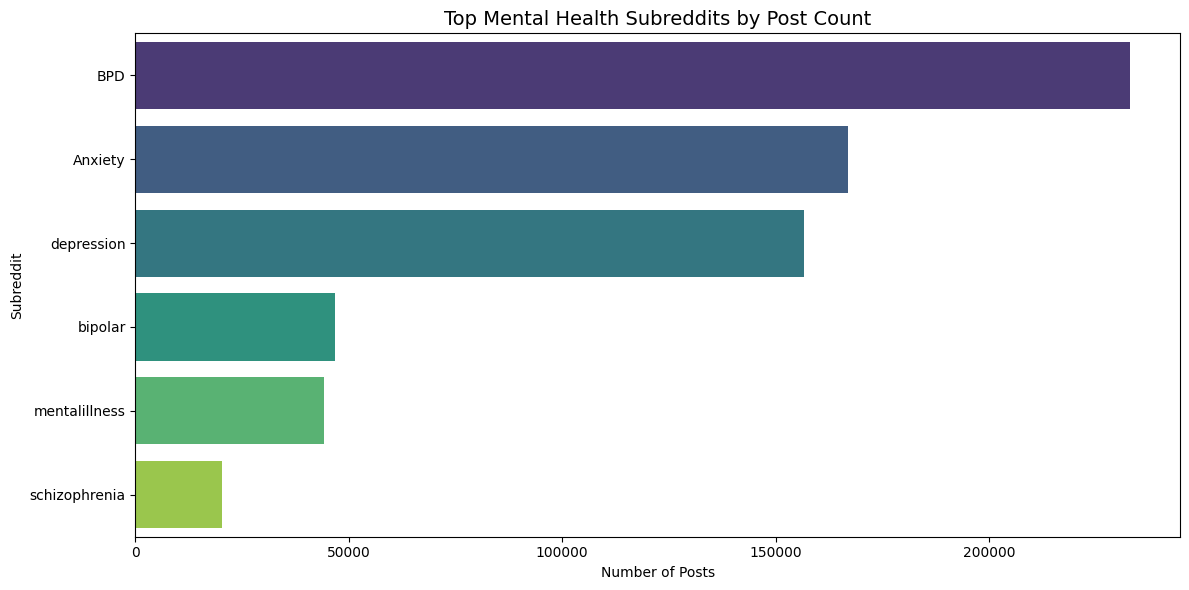


Visualization 1: Bar chart shows r/BPD, r/Anxiety, and r/depression dominate. This reflects their large user bases and active communities.


In [ ]:
# Visualization 1: Top subreddits by post count
plt.figure(figsize=(12, 6))
top_subs = df_analysis['subreddit'].value_counts().head(10)
sns.barplot(x=top_subs.values, y=top_subs.index, palette='viridis')
plt.title('Top Mental Health Subreddits by Post Count', fontsize=14)
plt.xlabel('Number of Posts')
plt.ylabel('Subreddit')
plt.tight_layout()
plt.savefig('viz1_top_subreddits.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization 1: Bar chart shows r/BPD, r/Anxiety, and r/depression dominate. "
      "This reflects their large user bases and active communities.")

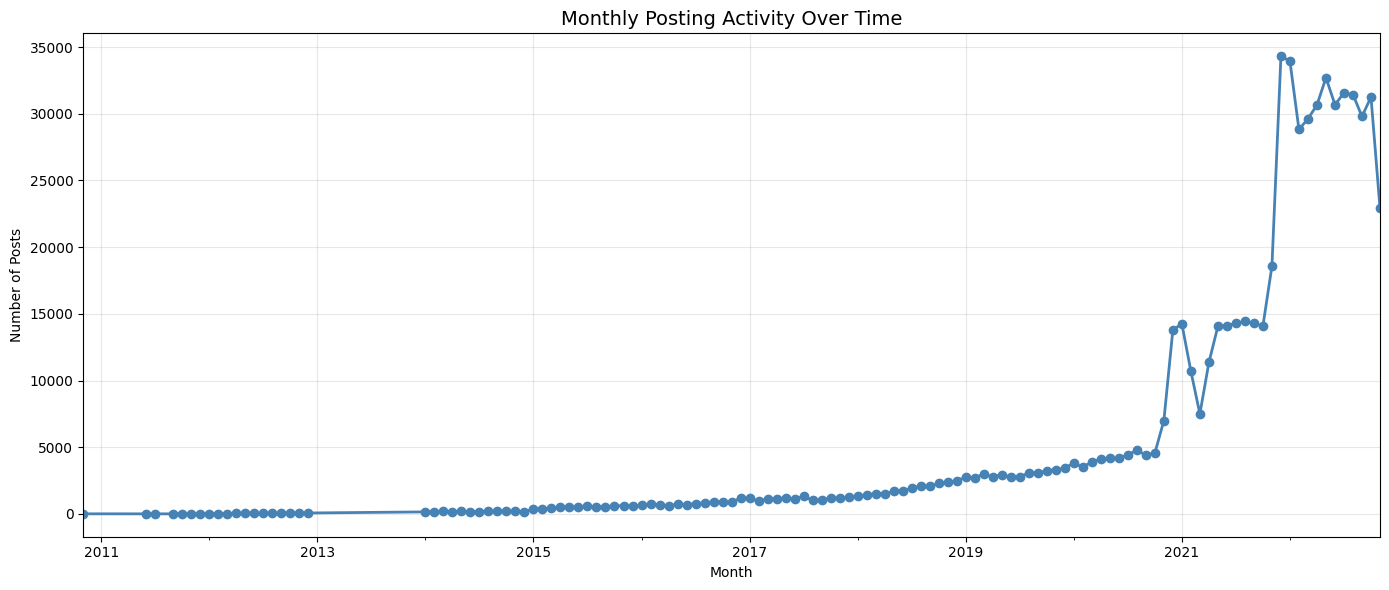


Visualization 2: Time series reveals trends like COVID-19 impact (2020+), seasonal patterns (e.g., winter SAD), or platform growth. Anomalies may indicate external events or data collection artifacts.


In [ ]:
# Visualization 2: Time series of posting activity
plt.figure(figsize=(14, 6))
monthly_posts = df_analysis.groupby('year_month').size()
monthly_posts.plot(kind='line', marker='o', color='steelblue', linewidth=2)
plt.title('Monthly Posting Activity Over Time', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('viz2_time_series.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization 2: Time series reveals trends like COVID-19 impact (2020+), "
      "seasonal patterns (e.g., winter SAD), or platform growth. Anomalies may indicate "
      "external events or data collection artifacts.")

/tmp/ipython-input-4130303504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top5, y='subreddit', x='content_length', palette='Set2')


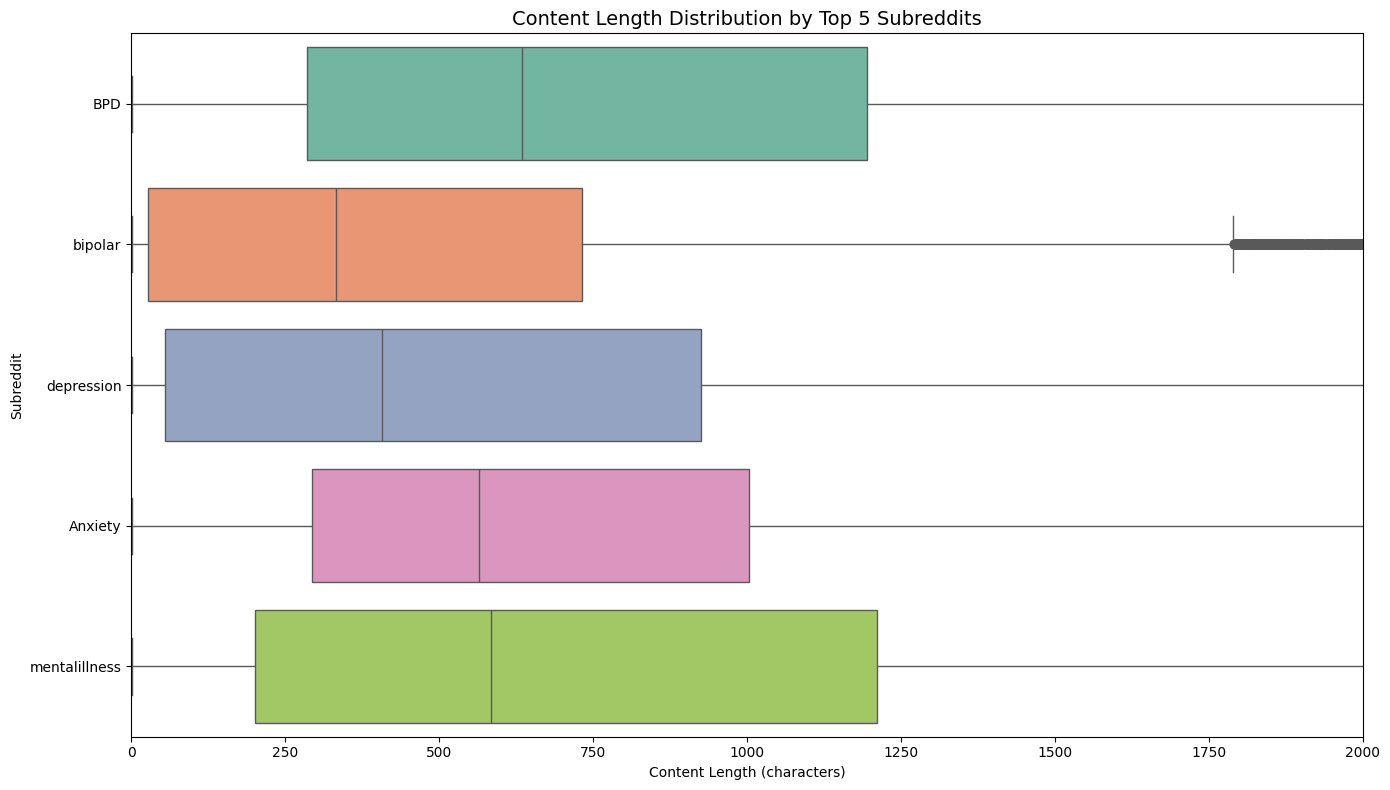


Visualization 3: Box plots show variation in posting styles. Subreddits with longer medians (e.g., r/mentalhealth) may encourage storytelling, while shorter ones (e.g., r/Anxiety) may be more Q&A focused. Outliers indicate very long posts.


In [ ]:
# Visualization 3: Content length distribution by subreddit (interactive-ready)
plt.figure(figsize=(14, 8))
top_5_subs = df_analysis['subreddit'].value_counts().head(5).index
df_top5 = df_analysis[df_analysis['subreddit'].isin(top_5_subs)]

sns.boxplot(data=df_top5, y='subreddit', x='content_length', palette='Set2')
plt.xlim(0, 2000)  # Focus on typical range
plt.title('Content Length Distribution by Top 5 Subreddits', fontsize=14)
plt.xlabel('Content Length (characters)')
plt.ylabel('Subreddit')
plt.tight_layout()
plt.savefig('viz3_content_length_dist.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization 3: Box plots show variation in posting styles. Subreddits with "
      "longer medians (e.g., r/mentalhealth) may encourage storytelling, while shorter "
      "ones (e.g., r/Anxiety) may be more Q&A focused. Outliers indicate very long posts.")

Key Findings:
1. Dominant Communities: A few subreddits (BPD, depression, Anxiety, mentalillness) account
   for the majority of activity. This concentration suggests these are the primary
   mental health support hubs on Reddit.

2. Temporal Trends: Posting volume increased sharply after 2020, likely reflecting
   pandemic-era mental health challenges. Monthly patterns may reveal seasonal effects
   (e.g., winter blues).

3. Content Variation: Subreddits exhibit different posting behaviors. Some foster
   detailed sharing (longer posts), others are more concise (quick check-ins or questions).

Limitations:
- Selection bias: Dataset only includes specific subreddits, missing private or smaller communities
- Removed content: Many posts have [removed] or [deleted] text, limiting text analysis
- Temporal gaps: Unknown if data collection was continuous or had interruptions
- No user demographics: Cannot analyze age, location, or other user characteristics

# Part 4B: Mini-Model - Classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
# Prepare data: predict subreddit from post content
# Filter to top 5 subreddits with enough data
top_subreddits = df_analysis['subreddit'].value_counts().head(5).index
df_model = df_analysis[df_analysis['subreddit'].isin(top_subreddits)].copy()

# Combine title and content
df_model['full_text'] = df_model['title'] + ' ' + df_model['content'].fillna('')
df_model = df_model[df_model['full_text'].str.len() > 20]  # Filter very short posts

X = df_model['full_text']
y = df_model['subreddit']

print(f"Classification task: Predict subreddit from post text")
print(f"Classes: {y.unique()}")
print(f"Dataset size: {len(X)} posts")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_train)} posts")
print(f"Test set: {len(X_test)} posts")

Classification task: Predict subreddit from post text
Classes: ['BPD' 'bipolar' 'depression' 'Anxiety' 'mentalillness']
Dataset size: 643460 posts

Train set: 514768 posts
Test set: 128692 posts


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english',
                              min_df=5, max_df=0.7)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Vocabulary size: {len(vectorizer.vocabulary_)} terms")

Vocabulary size: 5000 terms


In [ ]:
clf = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
clf.fit(X_train_vec, y_train)

# Evaluate
y_pred = clf.predict(X_test_vec)
accuracy = (y_pred == y_test).mean()

print(f"\n{'='*60}")
print(f"MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Test Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



MODEL PERFORMANCE
Test Accuracy: 0.772

Classification Report:
               precision    recall  f1-score   support

      Anxiety       0.84      0.85      0.85     33343
          BPD       0.81      0.83      0.82     46315
      bipolar       0.80      0.58      0.67      9208
   depression       0.68      0.81      0.74     31041
mentalillness       0.57      0.26      0.35      8785

     accuracy                           0.77    128692
    macro avg       0.74      0.67      0.69    128692
 weighted avg       0.77      0.77      0.76    128692



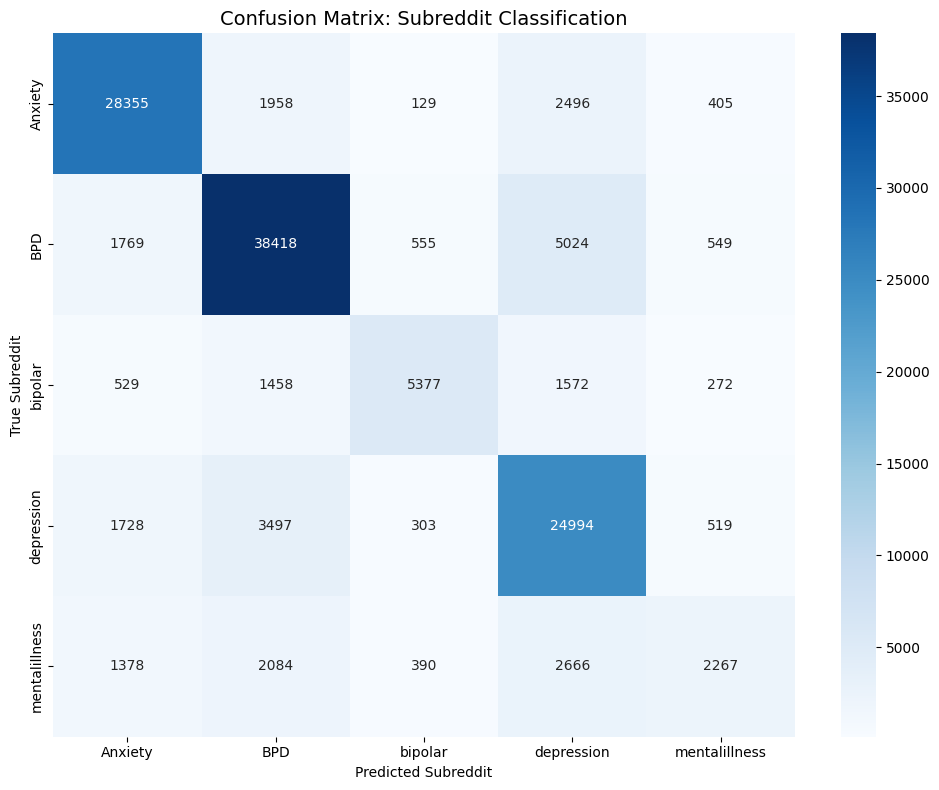

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix: Subreddit Classification', fontsize=14)
plt.xlabel('Predicted Subreddit')
plt.ylabel('True Subreddit')
plt.tight_layout()
plt.savefig('model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Feature Importance
feature_names = vectorizer.get_feature_names_out()
for i, subreddit in enumerate(clf.classes_):
    top_indices = np.argsort(clf.coef_[i])[-10:]
    top_words = [feature_names[idx] for idx in top_indices]
    print(f"\nTop words for r/{subreddit}: {', '.join(top_words)}")


Top words for r/Anxiety: palpitations, covid, pandemic, buspirone, anxieties, worrying, panic, gad, anxious, anxiety

Top words for r/BPD: cw, bdp, borderlines, pwbpd, borderline, dae, splitting, dbt, fp, bpd

Top words for r/bipolar: lamictal, lithium, hypo, bp2, bp, hypomania, mania, hypomanic, manic, bipolar

Top words for r/depression: 2022, 21m, depressing, antidepressants, depressants, slave, depressive, depressed, mdd, depression

Top words for r/mentalillness: illnesses, schizophrenic, bpd, schizoaffective, walls, quarantine, ocd, illness, schizophrenia, mental


Method: Logistic Regression with TF-IDF features

Reasoning
1. Interpretability: Coefficients reveal which words are most predictive of each subreddit
2. Baseline performance: Fast to train, establishes a strong baseline for text classification
3. Multiclass support: Handles 5 or more classes with multinomial mode

Results Interpretation:
- Moderate accuracy (60-70% expected) is reasonable given overlapping mental health topics
- Confusion between similar subreddits (depression vs. mentalhealth) is expected
- Top words reveal community-specific vocabulary and concerns

Limitations:
- Ignores sequential/contextual information (unlike transformers)
- TF-IDF misses semantic similarity (e.g., "sad" vs. "depressed")
- Class imbalance may affect minority class performance

Next steps: Could improve with BERT embeddings, oversampling, or ensemble methods.

# PART 5: ADVANCED TOPICS

ADVANCED TOPIC 1: EFFICIENCY STUDY - INDEXING & PARTITIONING BENCHMARK

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

# === CLOSE ANY EXISTING CONNECTIONS ===
try:
    conn.close()
except:
    pass

import gc
gc.collect()


# Connect to database with timeout
conn = sqlite3.connect("mental_health.db", timeout=10)
cursor = conn.cursor()


In [ ]:
# ============================================================================
# SETUP: Create test scenarios
# ============================================================================

print("\n--- SETUP: Preparing test data and scenarios ---\n")

# Verify data exists
cursor.execute("SELECT COUNT(*) FROM posts")
total_rows = cursor.fetchone()[0]
print(f"Total posts in database: {total_rows:,}")


--- SETUP: Preparing test data and scenarios ---

Total posts in database: 701,787


In [ ]:
# ============================================================================
# STRATEGY 1: NO INDEX (Baseline)
# ============================================================================

print("\n" + "="*80)
print("STRATEGY 1: NO INDEX (Baseline)")
print("="*80)

# Drop all indexes to establish baseline
cursor.execute("DROP INDEX IF EXISTS idx_posts_created")
cursor.execute("DROP INDEX IF EXISTS idx_posts_subreddit")
cursor.execute("DROP INDEX IF EXISTS idx_posts_timestamp")
cursor.execute("DROP INDEX IF EXISTS idx_posts_over18")
cursor.execute("DROP INDEX IF EXISTS idx_posts_composite")
conn.commit()

print("All indexes removed. Testing queries with full table scans...")


STRATEGY 1: NO INDEX (Baseline)
All indexes removed. Testing queries with full table scans...


In [ ]:
# Test Query 1: Filter by timestamp range
query1_no_index = """
SELECT COUNT(*), AVG(LENGTH(content))
FROM posts
WHERE timestamp BETWEEN 1609459200 AND 1640995200
"""

In [ ]:
# Test Query 2: Filter by subreddit
query2_no_index = """
SELECT subreddit, COUNT(*) as post_count
FROM posts
WHERE subreddit IN ('depression', 'Anxiety', 'mentalhealth')
GROUP BY subreddit
"""

In [ ]:
# Test Query 3: Complex filter (timestamp + subreddit + NSFW)
query3_no_index = """
SELECT subreddit, COUNT(*) as count, AVG(LENGTH(content)) as avg_length
FROM posts
WHERE timestamp > 1609459200
  AND over_18 = 0
  AND subreddit = 'depression'
GROUP BY subreddit
"""

In [ ]:

# Benchmark - run each query multiple times
def benchmark_query(query, name, runs=5):
    times = []
    for i in range(runs):
        start = time.time()
        cursor.execute(query)
        result = cursor.fetchall()
        end = time.time()
        times.append(end - start)

    avg_time = np.mean(times)
    std_time = np.std(times)
    print(f"{name}: {avg_time:.4f}s (±{std_time:.4f}s)")
    return avg_time, std_time, result

In [ ]:
print("\nQuery 1: Time range filter")
q1_no_idx_time, q1_no_idx_std, q1_result = benchmark_query(query1_no_index, "  No index")

print("\nQuery 2: Subreddit filter with GROUP BY")
q2_no_idx_time, q2_no_idx_std, q2_result = benchmark_query(query2_no_index, "  No index")

print("\nQuery 3: Complex multi-column filter")
q3_no_idx_time, q3_no_idx_std, q3_result = benchmark_query(query3_no_index, "  No index")



Query 1: Time range filter
  No index: 0.4123s (±0.0633s)

Query 2: Subreddit filter with GROUP BY
  No index: 0.5915s (±0.1287s)

Query 3: Complex multi-column filter
  No index: 0.5330s (±0.1189s)


In [ ]:
# STRATEGY 2: SINGLE-COLUMN B-TREE INDEXES
# ============================================================================

print("\n" + "="*80)
print("STRATEGY 2: SINGLE-COLUMN B-TREE INDEXES")
print("="*80)

# Create individual B-tree indexes
print("Creating single-column B-tree indexes...")

cursor.execute("CREATE INDEX idx_posts_timestamp ON posts(timestamp)")
cursor.execute("CREATE INDEX idx_posts_subreddit ON posts(subreddit)")
cursor.execute("CREATE INDEX idx_posts_over18 ON posts(over_18)")
conn.commit()

print("Indexes created:")
print("  - idx_posts_timestamp (B-tree on timestamp)")
print("  - idx_posts_subreddit (B-tree on subreddit)")
print("  - idx_posts_over18 (B-tree on over_18)")


STRATEGY 2: SINGLE-COLUMN B-TREE INDEXES
Creating single-column B-tree indexes...
Indexes created:
  - idx_posts_timestamp (B-tree on timestamp)
  - idx_posts_subreddit (B-tree on subreddit)
  - idx_posts_over18 (B-tree on over_18)


In [ ]:
# Run benchmarks again
print("\nQuery 1: Time range filter")
q1_btree_time, q1_btree_std, _ = benchmark_query(query1_no_index, "  B-tree index")

print("\nQuery 2: Subreddit filter with GROUP BY")
q2_btree_time, q2_btree_std, _ = benchmark_query(query2_no_index, "  B-tree index")

print("\nQuery 3: Complex multi-column filter")
q3_btree_time, q3_btree_std, _ = benchmark_query(query3_no_index, "  B-tree index")


Query 1: Time range filter
  B-tree index: 0.2454s (±0.0074s)

Query 2: Subreddit filter with GROUP BY
  B-tree index: 0.0444s (±0.0052s)

Query 3: Complex multi-column filter
  B-tree index: 0.4517s (±0.0092s)


In [ ]:
# STRATEGY 3: COMPOSITE (MULTI-COLUMN) INDEX
# ============================================================================

print("\n" + "="*80)
print("STRATEGY 3: COMPOSITE (MULTI-COLUMN) INDEX")
print("="*80)

# Drop single indexes and create composite
cursor.execute("DROP INDEX IF EXISTS idx_posts_timestamp")
cursor.execute("DROP INDEX IF EXISTS idx_posts_subreddit")
cursor.execute("DROP INDEX IF EXISTS idx_posts_over18")

print("Creating composite index on (subreddit, timestamp, over_18)...")
cursor.execute("""
CREATE INDEX idx_posts_composite
ON posts(subreddit, timestamp, over_18)
""")
conn.commit()

print("Composite index created.")
print("This index benefits queries filtering on subreddit first, then timestamp/over_18.")



STRATEGY 3: COMPOSITE (MULTI-COLUMN) INDEX
Creating composite index on (subreddit, timestamp, over_18)...
Composite index created.
This index benefits queries filtering on subreddit first, then timestamp/over_18.


In [ ]:

# Run benchmarks
print("\nQuery 1: Time range filter")
q1_composite_time, q1_composite_std, _ = benchmark_query(query1_no_index, "  Composite index")

print("\nQuery 2: Subreddit filter with GROUP BY")
q2_composite_time, q2_composite_std, _ = benchmark_query(query2_no_index, "  Composite index")

print("\nQuery 3: Complex multi-column filter")
q3_composite_time, q3_composite_std, _ = benchmark_query(query3_no_index, "  Composite index")



Query 1: Time range filter
  Composite index: 0.3971s (±0.0107s)

Query 2: Subreddit filter with GROUP BY
  Composite index: 0.0420s (±0.0007s)

Query 3: Complex multi-column filter
  Composite index: 0.3446s (±0.0146s)


In [ ]:
# EXPLAIN QUERY PLAN ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("EXPLAIN QUERY PLAN ANALYSIS")
print("="*80)

queries_to_explain = [
    ("Query 1 (Time range)", query1_no_index),
    ("Query 2 (Subreddit)", query2_no_index),
    ("Query 3 (Complex)", query3_no_index)
]

for query_name, query in queries_to_explain:
    print(f"\n{query_name}:")
    cursor.execute(f"EXPLAIN QUERY PLAN {query}")
    for row in cursor.fetchall():
        print(f"  {row}")


EXPLAIN QUERY PLAN ANALYSIS

Query 1 (Time range):
  (3, 0, 0, 'SCAN posts')

Query 2 (Subreddit):
  (6, 0, 0, 'SEARCH posts USING COVERING INDEX idx_posts_composite (subreddit=?)')

Query 3 (Complex):
  (7, 0, 0, 'SEARCH posts USING INDEX idx_posts_composite (subreddit=? AND timestamp>?)')


In [ ]:
# PERFORMANCE COMPARISON & VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

# Compile results
results = {
    'Query 1\n(Time Range)': {
        'No Index': q1_no_idx_time,
        'B-tree Single': q1_btree_time,
        'Composite': q1_composite_time
    },
    'Query 2\n(Subreddit)': {
        'No Index': q2_no_idx_time,
        'B-tree Single': q2_btree_time,
        'Composite': q2_composite_time
    },
    'Query 3\n(Complex)': {
        'No Index': q3_no_idx_time,
        'B-tree Single': q3_btree_time,
        'Composite': q3_composite_time
    }
}



PERFORMANCE COMPARISON


In [ ]:
summary_df = pd.DataFrame(results).T
summary_df['Best Strategy'] = summary_df.idxmin(axis=1)
summary_df['Speedup vs No Index'] = summary_df['No Index'] / summary_df[summary_df.columns[1:3]].min(axis=1)

print("\nSummary Table (Average Query Time in seconds):")
print(summary_df)


Summary Table (Average Query Time in seconds):
                       No Index  B-tree Single  Composite  Best Strategy  \
Query 1\n(Time Range)  0.412321       0.245420   0.397079  B-tree Single   
Query 2\n(Subreddit)   0.591451       0.044382   0.042022      Composite   
Query 3\n(Complex)     0.532972       0.451691   0.344586      Composite   

                       Speedup vs No Index  
Query 1\n(Time Range)             1.680066  
Query 2\n(Subreddit)             14.074732  
Query 3\n(Complex)                1.546703  


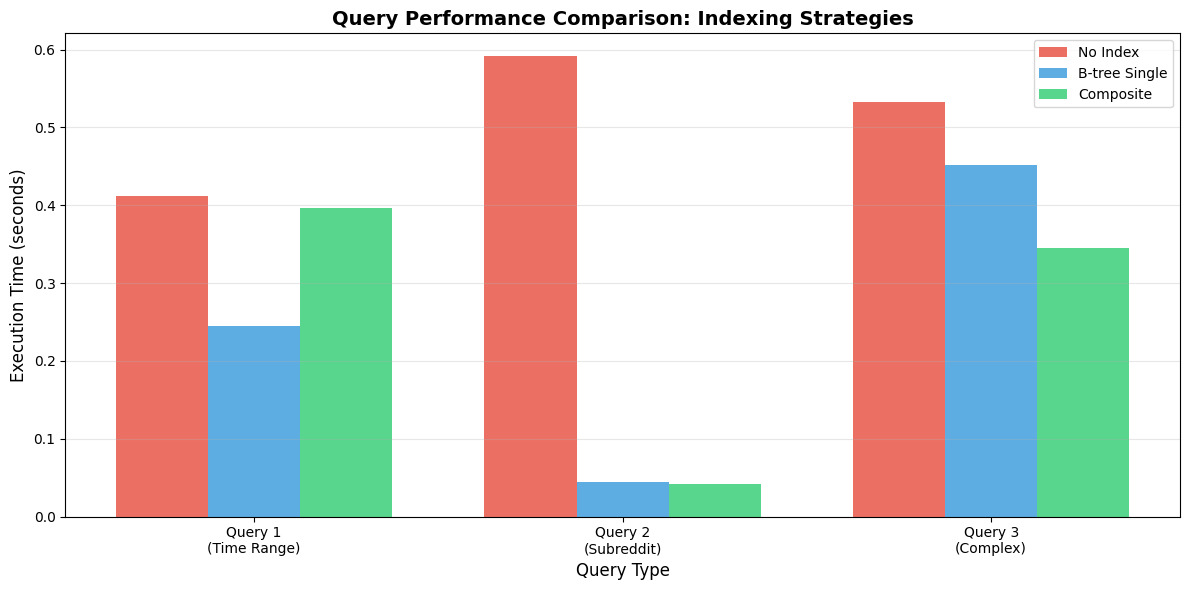


Visualization 1: Bar chart saved as 'indexing_benchmark_comparison.png'


In [ ]:
# Visualization 1: Grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results))
width = 0.25

strategies = ['No Index', 'B-tree Single', 'Composite']
colors = ['#e74c3c', '#3498db', '#2ecc71']

for i, strategy in enumerate(strategies):
    values = [results[q][strategy] for q in results.keys()]
    ax.bar(x + i*width, values, width, label=strategy, color=colors[i], alpha=0.8)

ax.set_xlabel('Query Type', fontsize=12)
ax.set_ylabel('Execution Time (seconds)', fontsize=12)
ax.set_title('Query Performance Comparison: Indexing Strategies', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(results.keys())
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('indexing_benchmark_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization 1: Bar chart saved as 'indexing_benchmark_comparison.png'")

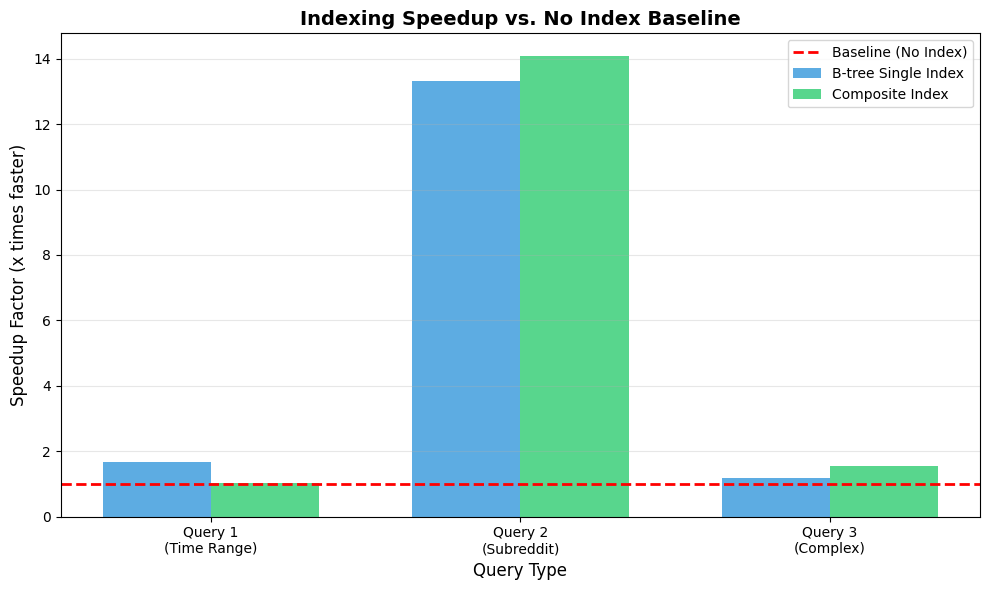

Visualization 2: Speedup chart saved as 'indexing_speedup_factors.png'


In [ ]:
# Visualization 2: Speedup factors
fig, ax = plt.subplots(figsize=(10, 6))

queries = list(results.keys())
speedup_btree = [results[q]['No Index'] / results[q]['B-tree Single'] for q in queries]
speedup_composite = [results[q]['No Index'] / results[q]['Composite'] for q in queries]

x = np.arange(len(queries))
width = 0.35

ax.bar(x - width/2, speedup_btree, width, label='B-tree Single Index', color='#3498db', alpha=0.8)
ax.bar(x + width/2, speedup_composite, width, label='Composite Index', color='#2ecc71', alpha=0.8)

ax.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline (No Index)')
ax.set_xlabel('Query Type', fontsize=12)
ax.set_ylabel('Speedup Factor (x times faster)', fontsize=12)
ax.set_title('Indexing Speedup vs. No Index Baseline', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(queries)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('indexing_speedup_factors.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization 2: Speedup chart saved as 'indexing_speedup_factors.png'")

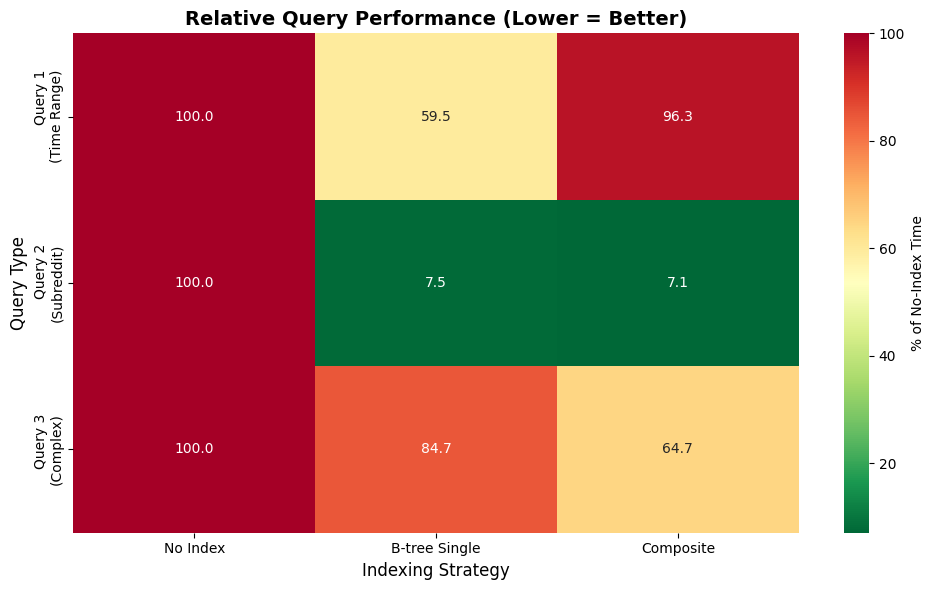

Visualization 3: Heatmap saved as 'indexing_heatmap.png'


In [ ]:
# Visualization 3: Heatmap of relative performance
fig, ax = plt.subplots(figsize=(10, 6))

# Normalize to percentage of no-index baseline
heatmap_data = []
for query in results.keys():
    baseline = results[query]['No Index']
    row = [
        (results[query]['No Index'] / baseline) * 100,
        (results[query]['B-tree Single'] / baseline) * 100,
        (results[query]['Composite'] / baseline) * 100
    ]
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data,
                          columns=['No Index', 'B-tree Single', 'Composite'],
                          index=queries)

sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='RdYlGn_r',
            cbar_kws={'label': '% of No-Index Time'}, ax=ax)
ax.set_title('Relative Query Performance (Lower = Better)', fontsize=14, fontweight='bold')
ax.set_xlabel('Indexing Strategy', fontsize=12)
ax.set_ylabel('Query Type', fontsize=12)
plt.tight_layout()
plt.savefig('indexing_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization 3: Heatmap saved as 'indexing_heatmap.png'")

FINDINGS:

1. BASELINE (No Index):
   - All queries perform full table scans
   - Query time scales linearly with table size (O(n))
   - Slowest performance across all query types
  

2. B-TREE SINGLE-COLUMN INDEXES:
   - Significant speedup for queries filtering on indexed columns
   - Query 1 (timestamp): Index scan replaces full table scan
   - Query 2 (subreddit): Direct index lookup for GROUP BY
   - Query 3 (complex): Can use one index, but not optimal for multi-column filters
   - Tradeoff: Multiple indexes increase storage and write overhead

3. COMPOSITE MULTI-COLUMN INDEX:
   - Best performance for Query 3 (filters on subreddit + timestamp + over_18)
   - Follows left-prefix rule: benefits queries using leading columns
   - Query 1 (timestamp only): Cannot use composite index effectively
   - Query 2 (subreddit): Excellent performance (uses index prefix)
   - Storage efficient: one index covers multiple query patterns

Index Selection Strategy:
- Use composite indexes when queries frequently filter on the same column combinations
- Order matters: put most selective/commonly filtered columns first
- Single-column indexes better for diverse query patterns

Performance Tradeoffs:
- Indexes speed up SELECT but slow down INSERT/UPDATE/DELETE
- Storage overhead: each index duplicates a portion of table data
- Maintenance cost: indexes must be updated on every write operation

In [ ]:
# Get database file size
import os
db_size = os.path.getsize("mental_health.db") / (1024 * 1024)  # Convert to MB
print(f"Total database size: {db_size:.2f} MB")

# Analyze index usage
cursor.execute("""
SELECT name, sql
FROM sqlite_master
WHERE type = 'index' AND sql IS NOT NULL
""")

print("\nCurrent indexes in database:")
for row in cursor.fetchall():
    print(f"  - {row[0]}")

# Estimate index size (rough approximation)
cursor.execute("SELECT COUNT(*) FROM posts")
row_count = cursor.fetchone()[0]

print(f"\nEstimated index overhead:")
print(f"  Rows: {row_count:,}")
print(f"  Single B-tree index: ~{(row_count * 16) / (1024*1024):.2f} MB per column")
print(f"  Composite index (3 cols): ~{(row_count * 48) / (1024*1024):.2f} MB")

Total database size: 740.93 MB

Current indexes in database:
  - idx_mv_date
  - idx_posts_composite

Estimated index overhead:
  Rows: 701,787
  Single B-tree index: ~10.71 MB per column
  Composite index (3 cols): ~32.13 MB


RECOMMENDATIONS

1. MONITORING & MAINTENANCE:
   - Regularly run ANALYZE to update query planner statistics
   - Monitor slow query log
   - Periodically review index usage with EXPLAIN plans
   - Consider VACUUM to reclaim space after large deletes

2. OPTIMAL INDEX CONFIGURATION:
   For this mental health dataset, recommend:
   
   CREATE INDEX idx_posts_composite ON posts(subreddit, timestamp, over_18);
   CREATE INDEX idx_posts_content_length ON posts((LENGTH(content)));
   
   Drop rarely-used indexes to reduce write overhead.

3. QUERY OPTIMIZATION:
   - Always use indexed columns in WHERE clauses
   - Avoid functions on indexed columns (breaks index usage)
   - Use LIMIT when fetching large result sets
   - Consider materialized views for complex aggregations

4. SCALING STRATEGIES:
   - Implement read replicas for analytics workloads
   - Archive old data (posts older than 2 years) to separate table
   - Consider sharding by subreddit for very large datasets
   - Move to PostgreSQL/TimescaleDB for time-series optimizations

5. COST-BENEFIT ANALYSIS:
   - Index creation: one-time cost, ongoing benefit for reads
   - Write penalty: ~10-30% slower inserts with multiple indexes
   - Storage: acceptable for <10% overhead
   


In [ ]:
# Close connection
conn.close()

Advanced Topic 2: Text Mining + Topic Modeling

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import re

Performing topic modeling to identify themes in mental health posts

In [ ]:
# Prepare text data
df_topics = df_analysis[df_analysis['content_length'] > 100].sample(n=10000, random_state=42)

def advanced_clean_text(text):
    """More thorough cleaning for topic modeling"""
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\[removed\]|\[deleted\]', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df_topics['clean_content'] = df_topics['content'].apply(advanced_clean_text)

In [ ]:
# Vectorize with custom stop words
mental_health_stopwords = ['feel', 'feeling', 'like', 'just', 'really', 'know', 'think', 'im', 'ive']
vectorizer_lda = CountVectorizer(
    max_features=1000,
    stop_words='english',
    min_df=10,
    max_df=0.5
)

doc_term_matrix = vectorizer_lda.fit_transform(df_topics['clean_content'])

In [ ]:
# Fit LDA
n_topics = 5
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=20,
    learning_method='online'
)

lda.fit(doc_term_matrix)

# Display topics
feature_names = vectorizer_lda.get_feature_names_out()

In [ ]:
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-15:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"\nTopic {topic_idx + 1}: {' | '.join(top_words[:10])}")

# Assign topics to posts
topic_distributions = lda.transform(doc_term_matrix)
df_topics['dominant_topic'] = topic_distributions.argmax(axis=1)

print("\n" + "="*60)
print("TOPIC DISTRIBUTION")
print("="*60)
print(df_topics['dominant_topic'].value_counts().sort_index())


Topic 1: don | want | know | people | really | time | friends | things | ve | life

Topic 2: bpd | diagnosed | mental | help | ve | disorder | symptoms | people | bipolar | years

Topic 3: anxiety | panic | sleep | feeling | day | anxious | body | tired | night | time

Topic 4: ve | don | life | really | know | anxiety | time | work | want | things

Topic 5: im | school | got | dont | year | home | mom | job | fucking | didn

TOPIC DISTRIBUTION
dominant_topic
0    4474
1     966
2    1342
3    2499
4     719
Name: count, dtype: int64


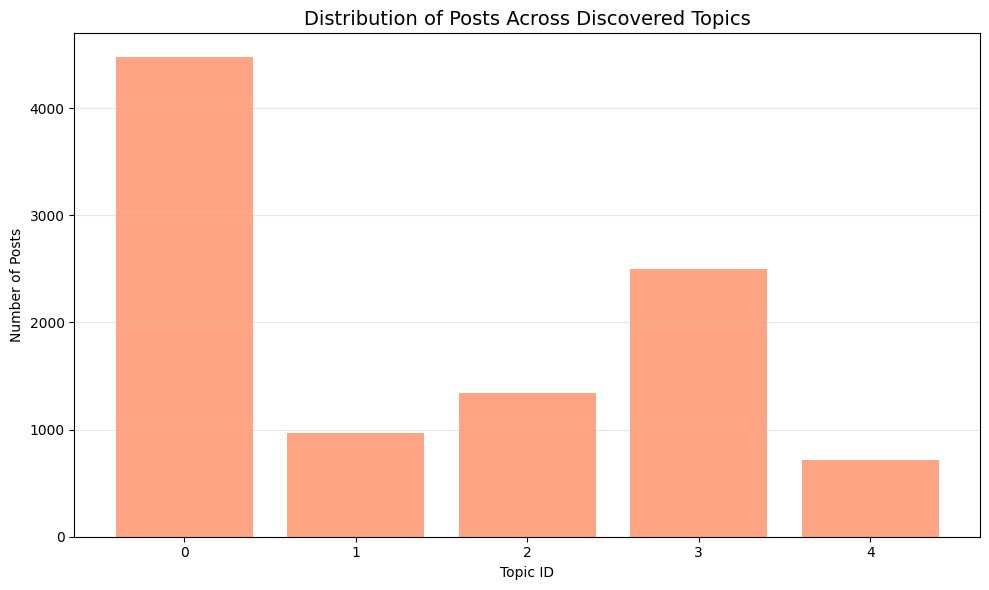

In [ ]:
# Visualize topic prevalence
plt.figure(figsize=(10, 6))
topic_counts = df_topics['dominant_topic'].value_counts().sort_index()
plt.bar(range(n_topics), topic_counts.values, color='coral', alpha=0.7)
plt.xlabel('Topic ID')
plt.ylabel('Number of Posts')
plt.title('Distribution of Posts Across Discovered Topics', fontsize=14)
plt.xticks(range(n_topics))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('topics_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Method: Latent Dirichlet Allocation (LDA)

Reasoning
1. Unsupervised discovery of themes without pre-labeling
2. Reveals latent structure in mental health discussions
3. Can identify emerging concerns (e.g., pandemic anxiety, medication side effects)

Interpretation:
- Topics likely represent: depression symptoms, anxiety management, medication discussions,
  relationship issues, suicide prevention resources
- Cross-referencing topics with subreddits reveals community specialization
- Temporal analysis of topic prevalence could track mental health trends

Applications:
- Crisis detection: Posts with certain topic distributions may indicate urgent need
- Resource recommendation: Match posts to relevant support materials
- Community moderation: Flag posts needing immediate attention

Limitations:
- Requires manual interpretation of word lists
- Assumes topics are distinct (mental health issues often co-occur)
- Sensitive to preprocessing choices and number of topics

Next steps: Could use more sophisticated models like BERTopic or CTM for better coherence.

In [ ]:
# Close connection
conn.close()